# part0: imports

In [1]:
import os, sys, pathlib
from pprint import pprint 
from importlib import reload
import logging
from typing import Callable
logging.basicConfig(level=logging.ERROR)
import warnings
warnings.simplefilter("ignore")



import pandas as pd
import numpy as np
import xarray as xr
from sklearn.decomposition import PCA
import scipy.linalg as linalg

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator


from tools import utilityTools as utility
from tools import dataTools as dt
import pyaldata as pyal

%matplotlib inline
reload(dt)

root = pathlib.Path("/data")

# Compare different epochs

the idea is to see whether canonical axes between 2 animals provide a higher VAF for time epochs in the trial that they have not been trained on, compared to, for example, M1-PMd axes in a single animal.

preprocessing

In [2]:
def get_target_id(trial):
    return int(np.round((trial.target_direction + np.pi) / (0.25*np.pi))) - 1

Based on the Gallego Nat Comm 2018 paper and some playing (data and projection matrices in the paper are row-wise): 
$$\%VAF=\frac{norm(X)-norm(X-XC^TA(A^TA)^{-1}A^TC)}{norm(X)}$$
where:
- $A$ is the CCA output, the output of the `canoncorr` function
- $C$ is the `PCA_model.components_`
- $X$ is the data matrix, $T\times n$ with $T$ time points and $n$ neurons, and each neuron is **zero mean**
- $norm$ is sum of squared elements  

Seems to give reasonable results: lowering number of PCs reduces the VAF.

However, there are problems:
- the formulation in the paper, gives a VAF for each dimension, so the formula above should be applied to individual axes.
- It is already implemented in MATLAB [here](https://github.com/limblab/proc-juan/blob/65dd81a1fc0ddb23def8039df9053a2be3e9bf88/paper_cross-task_manifold_review/vaf_CCs.m#L114), which uses the VAF function from the dPCA paper [here](https://github.com/machenslab/dPCA/blob/master/matlab/dpca_explainedVariance.m). I should translate that to compare?!?

> The value above actually equals to the total VAF :)

### dimension-wise VFA

done!

---

back to the original idea:

1. this:
> # Compare different epochs
> the idea is to see whether canonical axes between 2 animals provide a higher VAF for time epochs in the trial that they have not been trained on, compared to, for example, M1-PMd axes in a single animal.

2. and a similar but different idea:
> two monkeys during the same epoch vs. one monkey between 2 different epochs.
i.e., preparation vs execution, ...

3. upper bound for VAF and for CCs:
> within monkey and epoch and even target-matched, randomly select 2 subset of trials and the VAF/CCs will be the upper bound.

#### Try the second idea first:

In [3]:
animalList = ['Chewie', 'Mihili']

animalFiles={}
for animal in animalList:
    animalFiles[animal] = utility.find_file(root / animal,'mat')

# just keeping the CS sessions
goodFiles = [file for animal in animalFiles for file in animalFiles[animal] if 'CS' in file]

# keeping 1 session per animal
fileList = ['/data/Chewie/Chewie_CO_CS_2016-10-14.mat', '/data/Mihili/Mihili_CO_VR_2014-03-03.mat']
# fileList = goodFiles


df_data=[]
for fname in fileList:
    df = pyal.mat2dataframe(fname, shift_idx_fields=True)
    df_data.append(df)
    dt.summary(df)

Chewie 10-14-2016
time signals:['pos', 'vel', 'acc', 'force', 'M1_spikes', 'PMd_spikes']
M1_spikes units: 88
PMd_spikes units: 190
tasks in file: ['CO'], epochs: ['BL']

Mihili 03-03-2014
time signals:['pos', 'vel', 'acc', 'force', 'M1_spikes', 'PMd_spikes']
M1_spikes units: 51
PMd_spikes units: 66
tasks in file: ['CO'], epochs: ['AD' 'BL' 'WO']



preprocessing:

In [4]:
def prep_exec_all_targets (df, n_components=10):
    "preprocessing for execution eopch"
    df["target_id"] = df.apply(get_target_id, axis=1)  # add a field `target_id` with int values

    df_= pyal.select_trials(df, df.result== 'R')
    df_= pyal.select_trials(df_, df_.epoch=='BL')
    
    
    df_ = pyal.combine_time_bins(df_, 3)
    
    
    if "M1_spikes" in df_.columns:
        df_ = pyal.remove_low_firing_neurons(df_, "M1_spikes", 1)
        df_ = pyal.sqrt_transform_signal(df_, "M1_spikes")
    if "PMd_spikes" in df_.columns:
        df_ = pyal.remove_low_firing_neurons(df_, "PMd_spikes", 1)
        df_ = pyal.sqrt_transform_signal(df_, "PMd_spikes")
        
    
    df_= pyal.add_firing_rates(df_, 'smooth')
    
    
    df_ = pyal.restrict_to_interval(df_, start_point_name='idx_movement_on', rel_start=-1, rel_end=15)
    
    if "M1_spikes" in df_.columns:
        M1_rates = np.concatenate(df_.M1_rates.values, axis=0)
        pca_model = PCA(n_components=n_components, svd_solver='full');
        pca_model.fit(M1_rates);
        df_ = pyal.apply_dim_reduce_model(df_, pca_model, 'M1_rates', 'M1_pca');

    if "PMd_spikes" in df_.columns:
        PMd_rates = np.concatenate(df_.PMd_rates.values, axis=0)
        pca_model = PCA(n_components=n_components, svd_solver='full');
        pca_model.fit(PMd_rates);
        df_ = pyal.apply_dim_reduce_model(df_, pca_model, 'PMd_rates', 'PMd_pca');

    
    return df_


df_data_exec = [prep_exec_all_targets(df) for  df in df_data]

/home/msafaie/REPOS/MyPyalData/pyaldata/tools.py:936: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/msafaie/REPOS/MyPyalData/pyaldata/tools.py:936: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/msafaie/REPOS/MyPyalData/pyaldata/tools.py:936: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/msafaie/REPOS/MyPyalData/pyaldata/tools.py:936: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


In [5]:
def prep_prep_all_targets (df, n_components=10):
    "preprocessing for Preparation epoch"
    df["target_id"] = df.apply(get_target_id, axis=1)  # add a field `target_id` with int values

    df_= pyal.select_trials(df, df.result== 'R')
    df_= pyal.select_trials(df_, df_.epoch=='BL')
    
    
    df_ = pyal.combine_time_bins(df_, 3)
    
    
    if "M1_spikes" in df_.columns:
        df_ = pyal.remove_low_firing_neurons(df_, "M1_spikes", 1)
        df_ = pyal.sqrt_transform_signal(df_, "M1_spikes")
    if "PMd_spikes" in df_.columns:
        df_ = pyal.remove_low_firing_neurons(df_, "PMd_spikes", 1)
        df_ = pyal.sqrt_transform_signal(df_, "PMd_spikes")
        
    
    df_= pyal.add_firing_rates(df_, 'smooth')

    
    df_ = pyal.restrict_to_interval(df_, start_point_name='idx_movement_on', rel_start=-15, rel_end=1)
    
    if "M1_spikes" in df_.columns:
        M1_rates = np.concatenate(df_.M1_rates.values, axis=0)
        pca_model = PCA(n_components=n_components, svd_solver='full');
        pca_model.fit(M1_rates);
        df_ = pyal.apply_dim_reduce_model(df_, pca_model, 'M1_rates', 'M1_pca');

    if "PMd_spikes" in df_.columns:
        PMd_rates = np.concatenate(df_.PMd_rates.values, axis=0)
        pca_model = PCA(n_components=n_components, svd_solver='full');
        pca_model.fit(PMd_rates);
        df_ = pyal.apply_dim_reduce_model(df_, pca_model, 'PMd_rates', 'PMd_pca');

    
    return df_


df_data_prep = [prep_prep_all_targets(df) for  df in df_data]

/home/msafaie/REPOS/MyPyalData/pyaldata/tools.py:936: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/msafaie/REPOS/MyPyalData/pyaldata/tools.py:936: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/msafaie/REPOS/MyPyalData/pyaldata/tools.py:936: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/msafaie/REPOS/MyPyalData/pyaldata/tools.py:936: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


plot

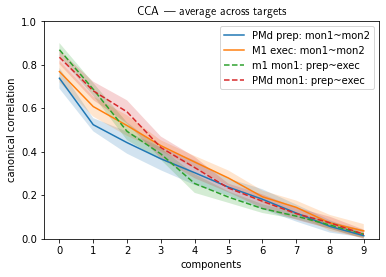

In [6]:
fig,ax = plt.subplots()

CC=[]
for target in range(8):
    dfs_prep = [pyal.select_trials(df_,df_.target_id==target) for df_ in df_data_prep]
    dfs_exec = [pyal.select_trials(df_,df_.target_id==target) for df_ in df_data_exec]
    
    # PMd prep: mon1~mon2
    CC.append(dt.CCA_pyal(dfs_prep[0],'PMd_pca', dfs_prep[1],'PMd_pca'))
    # M1 exec: mon1~mon2
    CC.append(dt.CCA_pyal(dfs_exec[0],'M1_pca', dfs_exec[1],'M1_pca'))
    # m1 mon1: prep~exec
    CC.append(dt.CCA_pyal(dfs_prep[0],'M1_pca', dfs_exec[0],'M1_pca'))
    # PMd mon1: prep~exec
    CC.append(dt.CCA_pyal(dfs_prep[0],'PMd_pca', dfs_exec[0],'PMd_pca'))

CC= np.array(CC)

utility.shaded_errorbar(ax,CC[0::4,:].T, label='PMd prep: mon1~mon2')
utility.shaded_errorbar(ax,CC[1::4,:].T, label='M1 exec: mon1~mon2')
utility.shaded_errorbar(ax,CC[2::4,:].T,ls='--',label='m1 mon1: prep~exec')
utility.shaded_errorbar(ax,CC[3::4,:].T,ls='--',label='PMd mon1: prep~exec')

ax.set_xlabel('components')
ax.set_ylabel('canonical correlation')
ax.legend()
ax.set_ylim([0,1])
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title('CCA --- average across targets', usetex=True);

similar results from prep~exec of Monkey2:


---

what about the VAF?  
I'll look at VAF, instead of correlation, in the plot above

In [7]:
def prep_general (df):
    "preprocessing general!"
    
    df["target_id"] = df.apply(get_target_id, axis=1)  # add a field `target_id` with int values

    df_= pyal.select_trials(df, df.result== 'R')
    df_= pyal.select_trials(df_, df_.epoch=='BL')
    
    df_ = pyal.combine_time_bins(df_, 3)
    
    if "M1_spikes" in df_.columns:
        df_ = pyal.remove_low_firing_neurons(df_, "M1_spikes", 1)
        df_ = pyal.sqrt_transform_signal(df_, "M1_spikes")
    if "PMd_spikes" in df_.columns:
        df_ = pyal.remove_low_firing_neurons(df_, "PMd_spikes", 1)
        df_ = pyal.sqrt_transform_signal(df_, "PMd_spikes")
        
    df_= pyal.add_firing_rates(df_, 'smooth')
    
    
    return df_


df_data_ready = [prep_general(df) for  df in df_data]

prep_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on', rel_start=-15, rel_end=1)
exec_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on', rel_start=-1, rel_end=15)

/home/msafaie/REPOS/MyPyalData/pyaldata/tools.py:936: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/msafaie/REPOS/MyPyalData/pyaldata/tools.py:936: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/msafaie/REPOS/MyPyalData/pyaldata/tools.py:936: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/msafaie/REPOS/MyPyalData/pyaldata/tools.py:936: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


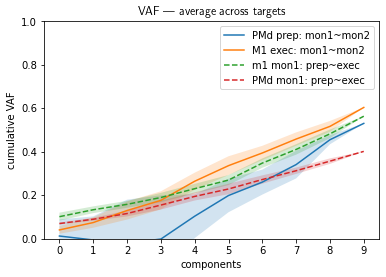

In [8]:
fig,ax = plt.subplots()


CC=[]

for target in range(8):
    # PMd prep: mon1~mon2
    a,b,_ = dt.VAF_pc_cc_pyal(df1=df_data_ready[1], field1='PMd_rates', epoch1=prep_epoch, target1=target,
                            df2=df_data_ready[0], field2='PMd_rates', epoch2=prep_epoch, target2=target)
    CC.append((a+b)/2)

    # M1 exec: mon1~mon2
    a,b,_ = dt.VAF_pc_cc_pyal(df1=df_data_ready[0], field1='M1_rates', epoch1=exec_epoch, target1=target,
                            df2=df_data_ready[1], field2='M1_rates', epoch2=exec_epoch, target2=target)
    CC.append((a+b)/2)

    # m1 mon1: prep~exec
    a,b,_ = dt.VAF_pc_cc_pyal(df1=df_data_ready[0], field1='M1_rates', epoch1=prep_epoch, target1=target,
                            df2=df_data_ready[0], field2='M1_rates', epoch2=exec_epoch, target2=target)
    CC.append((a+b)/2)

    # PMd mon1: prep~exec
    a,b,_ = dt.VAF_pc_cc_pyal(df1=df_data_ready[0], field1='PMd_rates', epoch1=prep_epoch, target1=target,
                            df2=df_data_ready[0], field2='PMd_rates', epoch2=exec_epoch, target2=target)
    CC.append((a+b)/2)


CC= np.array(CC)

utility.shaded_errorbar(ax,np.cumsum(CC[0::4,:].T,axis=0), label='PMd prep: mon1~mon2')
utility.shaded_errorbar(ax,np.cumsum(CC[1::4,:].T,axis=0), label='M1 exec: mon1~mon2')
utility.shaded_errorbar(ax,np.cumsum(CC[2::4,:].T,axis=0),ls='--',label='m1 mon1: prep~exec')
utility.shaded_errorbar(ax,np.cumsum(CC[3::4,:].T,axis=0),ls='--',label='PMd mon1: prep~exec')

ax.set_xlabel('components')
ax.set_ylabel('cumulative VAF')
ax.legend()
ax.set_ylim([0,1])
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title('VAF --- average across targets', usetex=True);

In [58]:
def VAF_pc_cc_pyal2(df1:pd.DataFrame, field1: str, epoch1, target1: int,
                    df2:pd.DataFrame, field2: str, epoch2, target2: int,
                    n_iter:int =20, n_components:int =10) -> (np.ndarray, np.ndarray):
    """
    Measure VAF for each CCA axis, between 2 DataFrames, fields, time epochs, and targets.
    epoch1, epoch2: an instance of the `pyal.generate_epoch_fun` function.
    """
    if "target_id" not in df1.columns:
        df1["target_id"] = df1.apply(get_target_id, axis=1)
    if "target_id" not in df2.columns:
        df2["target_id"] = df2.apply(get_target_id, axis=1)
 
    df1 = pyal.restrict_to_interval(df1,epoch_fun=epoch1)
    rates_1 = np.concatenate(df1[field1].values, axis=0)
    rates_1 -= np.mean(rates_1,axis=0)

    df2 = pyal.restrict_to_interval(df2, epoch_fun=epoch2)
    rates_2 = np.concatenate(df2[field2].values, axis=0)
    rates_2 -= np.mean(rates_2,axis=0)
    
    # PCA
    
    ## check for `n`
    n1 = rates_1.shape[1]
    n2 = rates_2.shape[1]
    n_s, n_l = min (n1, n2), max(n1, n2)
    
    if n1 >= n2:
        array1Bigger = True
    else:
        array1Bigger = False
    diffTooBig = (abs(n1-n2)/min(n1,n2) >= 2) or (abs(n1-n2) > 100)  # boolean

    rng = np.random.default_rng(12345)
    VAFs1, VAFs2, R = [], [], []
    if diffTooBig:
        logging.warning('correcting for number of units')
        for i in range(n_iter):
            idx = rng.permutation(np.arange(n_l))
            array_new = rates_1 if array1Bigger else rates_2
            array_new = array_new[:,idx][:,:n_s]
            
            array_new_model = PCA(n_components=n_components, svd_solver='full').fit(array_new)
            
            if array1Bigger:
                PCA_model = PCA(n_components=n_components, svd_solver='full').fit(rates_2)
            else:
                PCA_model = PCA(n_components=n_components, svd_solver='full').fit(rates_1)

            rates_1_model = array_new_model if array1Bigger else PCA_model
            rates_1_C = rates_1_model.components_
            df1_ = pyal.select_trials(df1, df1.target_id==target1)
            rates_1_target = np.concatenate(df1_[field1].values, axis=0)
            pca_1_target = rates_1_model.transform(rates_1_target[:,][idx][:,:n_s]) if array1Bigger else rates_1_model.transform(rates_1_target)

            rates_2_model = PCA_model if array1Bigger else array_new_model
            rates_2_C = rates_2_model.components_
            df2_ = pyal.select_trials(df2, df2.target_id==target2)
            rates_2_target = np.concatenate(df2_[field2].values, axis=0)
            pca_2_target = rates_2_model.transform(rates_2_target) if array1Bigger else rates_2_model.transform(rates_2_target[:,][idx][:,:n_s])

            # same number of timepoints in both matrices
            n_samples = min ([pca_1_target.shape[0], pca_2_target.shape[0]])
            pca_1_target = pca_1_target[:n_samples,:]
            pca_2_target = pca_2_target[:n_samples,:]

            A, B, r, _, _ = dt.canoncorr(pca_1_target, pca_2_target, fullReturn=True)
            V1 = dt.VAF_pc_cc(array_new if array1Bigger else rates_1, rates_1_C, A)
            V2 = dt.VAF_pc_cc(rates_2 if array1Bigger else array_new, rates_2_C, B)
            VAFs1.append(V1)
            VAFs2.append(V2)
            R.append(r)
            
    else:
        VAFs1,VAFs2,R = VAF_pc_cc_pyal(df1, field1, epoch1, target1,
                                       df2, field2, epoch2, target2)

    return np.array(VAFs1).T, np.array(VAFs2).T, np.array(R).T

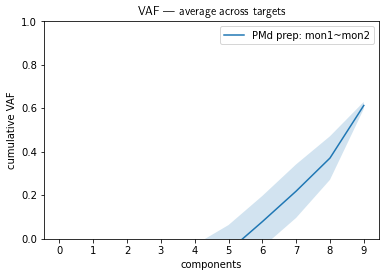

In [71]:
VAFs1,VAFs2,R = VAF_pc_cc_pyal2(df1=df_data_ready[1], field1='PMd_rates', epoch1=prep_epoch, target1=target,
                          df2=df_data_ready[0], field2='PMd_rates', epoch2=prep_epoch, target2=target)

_,ax=plt.subplots()
utility.shaded_errorbar(ax,np.cumsum((VAFs1+VAFs2)/2,axis=0), label='PMd prep: mon1~mon2')

ax.set_xlabel('components')
ax.set_ylabel('cumulative VAF')
ax.legend()
ax.set_ylim([0,1])
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title('VAF --- average across targets', usetex=True);

In [53]:
def PCA_n_corrected(array1:np.ndarray, array2:np.ndarray, n_iter:int =20, n_components:int =10):
    """
    Repeat PCA `n_iter` times by subsampling the larger dataset.

    Parameters
    ----------
    `array1` and `array2` are: time x units
    
    Returns
    -------
    `PCA_models1` and `PCA_models2`: lists containing PCA objects. If the number of units needs correction, lengths are bigger than 1.

    
    """
    n1 = array1.shape[1]
    n2 = array2.shape[1]
    n_s = min (n1, n2)
    
    if n1>=n2:
        array1Bigger = True
    else:
        array1Bigger = False
    
    diffTooBig = (abs(n1-n2)/min(n1,n2) >= 2) or (abs(n1-n2) > 100)  # boolean
    rng = np.random.default_rng(12345)

    PCA_models1, PCA_models2 = [], []
    if diffTooBig:
        PCA_models=[]
        for i in range(n_iter):
            array_new = rng.permutation(array1 if array1Bigger else array2, axis=1)[:,:n_s]
            array_new_model = PCA(n_components=n_components, svd_solver='full').fit(array_new)
            PCA_models.append(array_new_model)

        if array1Bigger:
            PCA_models1 = PCA_models
            PCA_models2.append(PCA(n_components=n_components, svd_solver='full').fit(array2))
            PCA_models2 *= n_iter
        else:
            PCA_models2 = PCA_models
            PCA_models1.append(PCA(n_components=n_components, svd_solver='full').fit(array1))
            PCA_models1 *= n_iter

    
    else:
        PCA_models1.append(PCA(n_components=n_components, svd_solver='full').fit(array1))
        PCA_models2.append(PCA(n_components=n_components, svd_solver='full').fit(array2))

    return PCA_models1, PCA_models2

In [69]:
VAFs2

array([[ 1.90466455e-02, -1.15041581e-02, -5.69847391e-02,
         3.35993646e-02, -9.31250583e-02,  5.78522967e-04,
        -2.41311275e-01,  2.46386038e-02,  5.31029889e-03,
         6.68418530e-03, -1.87440252e-01,  3.32543623e-02,
         7.66872262e-02, -1.87087267e-02,  2.77958018e-02,
         6.42354490e-02, -2.41459362e-02, -4.75889546e-02,
         3.20999462e-02,  3.50095649e-02],
       [ 7.40205570e-02,  4.11533329e-02,  4.68298778e-02,
         3.11412706e-02,  1.16937216e-01,  1.74927763e-02,
         9.94086719e-02,  2.53839177e-02,  3.14539410e-02,
        -5.17469324e-03, -8.85865405e-02, -7.42471585e-03,
         2.72376695e-02, -3.81299673e-03,  2.68792894e-02,
        -2.87180303e-02, -4.46563132e-02, -2.20096870e-02,
         3.17241025e-02,  7.21769023e-02],
       [ 2.66963259e-02,  4.89747577e-02,  5.43268857e-02,
        -9.39032398e-02,  5.14492753e-02,  3.86735838e-02,
        -3.43432632e-01,  3.96869446e-02,  5.66314096e-02,
         7.69302867e-02,  9.8